数据预处理，划分训练集、验证集、测试集

训练神经网络的过程:
1. 定义神经网络的结构和前向传播的输出结果  
   模型网络结构可视化
2. 定义损失函数以及选择方向传播优化算法
   
3. 在训练集上反复运行方向传播优化算法
   借助Tensorboard监控模型训练过程及效果
   
4. 模型保存
5. 载入模型进行预测

In [2]:
from __future__ import print_function
import numpy as np 
from os import makedirs
from os.path import exists, join

import keras
from keras.callbacks import TensorBoard 
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
import keras.backend as K

from keras.utils import plot_model

import matplotlib.pyplot as plt
%matplotlib inline

import pickle

import seaborn as sns
# use the FiveThirtyRight color scheme to make our charts look nice
five_thirty_eight = ["#30a2da","#fc4f30","#e5ae38","#6d904f","#8b8b8b",]
# Tell seaborn to use the 538 colors
sns.set_palette(five_thirty_eight)

C:\Users\huanglvjun\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# 定义参数
batch_size = 128
num_classes = 10
epochs = 10

img_rows, img_cols = 28, 28

log_dir = './logs'

if not exists(log_dir):
    makedirs(log_dir)

In [4]:
# 载入数据，进行数据预处理
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
# 训练集60000张图片， 测试集10000张图片，尺寸为28*28
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print(set(y_train))
print(set(y_test))
print('dtype: %s' %  y_train.dtype)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
dtype: uint8


Keras是一个模型级的库，提供了快速构建深度学习网络的模块。Keras并不处理如张量乘法、卷积等底层操作。这些操作依赖于某种特定的、优化良好的张量操作库。Keras依赖于处理张量的库就称为“后端引擎”。Keras提供了三种后端引擎Theano/Tensorflow/CNTK，并将其函数统一封装，使得用户可以以同一个接口调用不同后端引擎的函数。

不同后端引擎的"data_format"问题：
在如何表示一组彩色图片的问题上，Theano和TensorFlow发生了分歧，'th'模式，也即Theano模式会把100张RGB三通道的16×32（高为16宽为32）彩色图表示为下面这种形式（100,3,16,32），Caffe采取的也是这种方式。第0个维度是样本维，代表样本的数目，第1个维度是通道维，代表颜色通道数。后面两个就是高和宽了。这种theano风格的数据组织方法，称为“channels_first”，即通道维靠前。

而TensorFlow，的表达形式是（100,16,32,3），即把通道维放在了最后，这种数据组织方式称为“channels_last”。

因此，需在在网络的训练和测试中保持维度顺序一致。Keras默认的数据组织形式在~/.keras/keras.json中规定，可查看该文件的image_data_format一项查看，也可在代码中通过K.image_data_format()函数返回。

In [6]:
# 根据keras对图片格式的设置，调整图片维度顺序
if K.image_data_format == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# 将图片灰度值归一化到0-1范围内
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255

# 将类别label转为one-hot编码形式
print(y_test[0])
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
print(y_test[0])

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [7]:
# 定义网络结构和前向传播算法
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu', name='features'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [8]:
# 输出模型结构
plot_model(model=model, to_file='cnn_mnist_keras.png', show_layer_names=True, show_shapes=True)

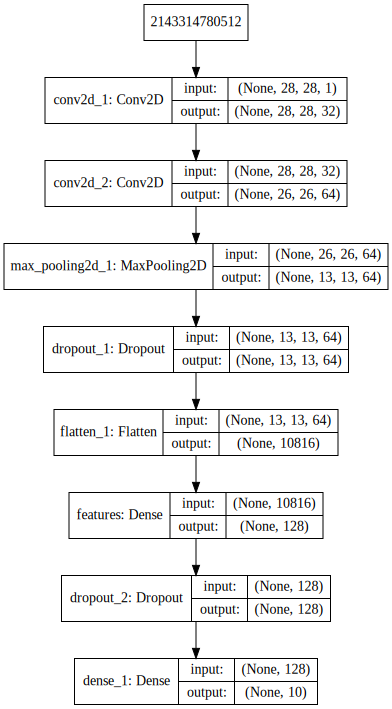

In [16]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [10]:
# save class labels to disk to color data points in TensorBoard accordingly
with open(join(log_dir, 'metadata.tsv'), 'w') as f:
    np.savetxt(f, y_test)

tensorboard = TensorBoard(batch_size=batch_size,
                          embeddings_freq=1,
                          embeddings_layer_names=['features'],
                          embeddings_metadata='metadata.tsv',
                          embeddings_data=x_test)

# You can now launch tensorboard with `tensorboard --logdir=./logs` on your
# command line and then go to http://localhost:6006/#projector to view the
# embeddings

In [11]:
# 定义损失函数以及选择方向传播优化算法
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.RMSprop(), metrics=['accuracy'])

# 在训练集上反复运行方向传播优化算法
history = model.fit(x_train[:100], y_train[:100], batch_size=batch_size, callbacks=[tensorboard], epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Train on 100 samples, validate on 10000 samples
Epoch 1/10
100/100 [==============================] - 9s 86ms/step - loss: 2.3081 - acc: 0.0800 - val_loss: 2.2455 - val_acc: 0.1873
Epoch 2/10
100/100 [==============================] - 8s 78ms/step - loss: 2.0473 - acc: 0.2400 - val_loss: 1.8975 - val_acc: 0.4610
Epoch 3/10
100/100 [==============================] - 7s 75ms/step - loss: 1.6499 - acc: 0.5200 - val_loss: 1.7915 - val_acc: 0.4484
Epoch 4/10
100/100 [==============================] - 8s 76ms/step - loss: 1.2921 - acc: 0.5800 - val_loss: 1.6972 - val_acc: 0.4609
Epoch 5/10
100/100 [==============================] - 7s 73ms/step - loss: 1.3375 - acc: 0.6100 - val_loss: 1.5023 - val_acc: 0.5610
Epoch 6/10
100/100 [==============================] - 7s 74ms/step - loss: 0.9645 - acc: 0.7500 - val_loss: 1.2269 - val_acc: 0.6373
Epoch 7/10
100/100 [==============================] - 7s 74ms/step - loss: 0.6357 - acc: 0.8200 - val_loss: 1.3207 - val_acc: 0.5920
Epoch 8/10
100/100 [=

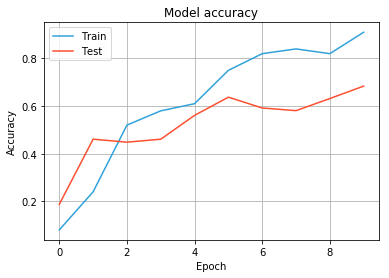

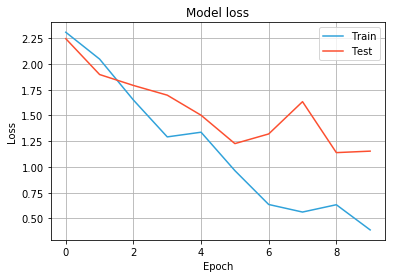

In [12]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.grid()
plt.show()

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print(score)

[1.1536598206520081, 0.6838]


In [14]:
# 保存模型
model.save('cnn_mnist_keras.model')

In [29]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5') 
# Returns a compiled model identical to the previous one
loaded_model = load_model('my_model.h5')

NameError: name 'model' is not defined

In [27]:
# evaluate loaded model on test data
loaded_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 68.38%


In [17]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [19]:
from keras.models import model_from_json, model_from_yaml

In [20]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:
# evaluate loaded model on test data
loaded_model.compile(loss=keras.losses.categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 68.38%


In [24]:
# serialize model to YAML
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")
 
# later...
 
# load YAML and create model
yaml_file = open('model.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Saved model to disk
Loaded model from disk
acc: 68.38%
